In [1]:
# general modules
import numpy as np
import h5py
import time
import matplotlib.pyplot as plt
import os
import datetime

# ML modules
import tensorflow as tf
#%load_ext tensorboard
from tensorflow.keras import datasets, layers, models
import tensorflow_addons as tfa
from sklearn.metrics import roc_curve, auc

# own modules
import sys
sys.path.append("../../") # go to parent dir
import iact_dnn_utils as utils
import dio3
import plot_utils


In [2]:
import importlib
importlib.reload(utils)

<module 'iact_dnn_utils' from '../../iact_dnn_utils.py'>

In [3]:
def get_max_Q(fpr, tpr):
    ind_mask = fpr > 1.e-10
    imax = np.argmax(tpr[ind_mask]/np.sqrt(fpr[ind_mask]))
    imax = np.arange(len(tpr), dtype=int)[imax]
    Rg = tpr[imax]
    Rp = fpr[imax]
    Qmax = Rg / np.sqrt(Rp)
    return imax, Rg, Rp, Qmax

In [64]:
case = 21
# temporary hack - in future load dicts for different cases
# baseline model for E > 1 TeV
cdict = {'mode':'mono',
         'tel':'MST_MST_FlashCam',
         #'tel':'LST_LST_LSTCam',
         'flatten':1,
        'Etrue_min':0.3,
        'n_events':10**5,
         #'n_events_gamma-diffuse':10**5,
         'folder_dl1':'/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/\
Prod5_Paranal_AdvancedBaseline_NSB1x_EventPlaceholder_North_20deg_ctapipe_v0.10.5_DL1/',
         'folder_square': '/home/saturn/caph/mpp228/CTA_data/Prod5_GRID/Prod5_square_images/',
         'folder_zeta': '/home/saturn/caph/mpp228/CTA_results/Prod5_GRID/Prod5_square_images_zeta/case1/',
         #'event_type':'proton',
         'model_events':{'proton':8*10**4, 'gamma-diffuse':8*10**4}, # 'proton', 'gamma-diffuse', 'electron'
         'data_key':'image_mask',
         'image_size':'None',
         'epochs': 10,
         #'mask_keys': ['hillas_intensity', 'leakage_pixels_width_2'],
         'mask_dict': {'hillas_intensity':{'min':200, 'max':10000, 'collapse_method':np.mean},
                        #'leakage_pixels_width_2':{'min':-1, 'max':1.5/110., 'collapse_method':np.min},
                       'hillas_r':{'min':0, 'max':1, 'collapse_method':np.mean},
                       'true_energy':{'min':1., 'max':4., 'collapse_method':np.mean},
                      },
         'load_model': None, #'case1',
         'zeta_mask': None,
         'two_step': 0,
         'dropout_rate': 0.,
        }
if case == 1:
    # train for 20 epochs without focal loss
    cdict['epochs'] = 20
    #cdict['load_model'] = 'case1'
if case == 2:
    cdict['epochs'] = 10
    gamma = 2
    alpha = 0.25
    cdict['gamma'] = gamma
    cdict['alpha'] = alpha
    cdict['two_step'] = 1
    cdict['load_model'] = 'case2'
if case == 3:
    cdict['epochs'] = 20
    cdict['mask_dict']['true_energy'] = {'min':10., 'max':1000., 'collapse_method':np.mean}
    cdict['mask_dict']['hillas_r'] = {'min':0, 'max':0.8, 'collapse_method':np.mean}
    cdict['model_events'] = {'proton':5*10**4, 'gamma-diffuse':5*10**4}
    cdict['load_model'] = None
    gamma = 0.5
    alpha = 0.4
    cdict['gamma'] = gamma
    cdict['alpha'] = alpha
    cdict['two_step'] = 1
if case == 4:
    cdict['epochs'] = 10
    cdict['dropout_rate'] = 0.2
    cdict['load_model'] = 'case4_part3' #'case4_part1'
    cdict['mask_dict']['hillas_r'] = {'min':0, 'max':0.9, 'collapse_method':np.mean}
    cdict['two_step'] = 1
    gamma = 0.1
    alpha = 0.4
    cdict['gamma'] = gamma
    cdict['alpha'] = alpha
    
if case == 10:
    # refinement for E > 10 TeV and a zeta cut on case 1
    cdict['zeta_mask'] = {'name':'case1', 'min':0.5, 'max':1.}
    cdict['load_model'] = 'case1'

if case == 21:
    cdict['tel'] = None
    cdict['epochs'] = 10
    cdict['dropout_rate'] = 0.2
    cdict['load_model'] = None
    cdict['n_events'] = 10**4
    cdict['mask_dict'] = {'camera_frame_hillas_intensity':{'min':200, 'max':10000, 'collapse_method':np.mean},
                       'camera_frame_hillas_r':{'min':0, 'max':1, 'collapse_method':np.mean},
                       'true_energy':{'min':1., 'max':4., 'collapse_method':np.mean},}
    cdict['two_step'] = 0
    cdict['model_events'] = {'proton':5*10**4, 'gamma':5*10**4} # 'proton', 'gamma-diffuse', 'electron'
    cdict['folder_square'] = '/home/saturn/caph/mpp228/HESS_data/HESS_data_MC/sim_telarray/\
phase2d/sim_telarray/phase2d/0.0deg/Data_square/'
#date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#date = log_dir.split('/')[-1]

In [65]:
cdict_fn = '../config/cdict_case%i.yaml' % case
#cdict['folder_zeta'] += 'case%i/' % case
dio3.savedict(cdict, cdict_fn, expand=True)

plot_ROC_only = False
if plot_ROC_only:
    cdict['mask_dict']['true_energy'] = {'min':10., 'max':100., 'collapse_method':np.mean}
    cdict['model_events'] = {'proton':10**4, 'gamma-diffuse':10**4}
    cdict['load_model'] = 'case%i' % case


save dict to file:
../config/cdict_case21.yaml


In [66]:
# common parameters
image_keys = ['image', 'image_mask']
pars_keys = ['CR_type', 'true_energy'] # to be extended from .h5 file
epochs = cdict['epochs']
dropout_rate = cdict['dropout_rate']

image_size = cdict['image_size'] # 40 - if crop
train_fraction = 0.6
#mask_dict = {'hillas_intensity':{'min':200, 'max':10000, 'collapse_method':np.mean},
#            'leakage_pixels_width_2':{'min':-1, 'max':1.5/110., 'collapse_method':np.min},}
mask_dict = cdict['mask_dict']
apply_mask = True
if apply_mask:
    pars_keys.extend(list(mask_dict.keys()))
print(pars_keys)

# selection parameters
folder = cdict['folder_square']
ev_types = ['proton', 'gamma-diffuse']
n_events = cdict['n_events']
mode = cdict['mode']
#n_events = 1000
data_key = cdict['data_key'] # 'image', 'image_mask'
y_key = 'CR_type'

# model description
model_descr_str = 'case%i' % (case)
save_model = True
test_train = 1
save_plots = 1
publish_version = 1
plot_utils.setup_figure_pars()

mdl_folder = '../models'
if not os.path.isdir(mdl_folder):
    os.makedirs(mdl_folder)
mdl_fn = '%s/model_%s.h5' % (mdl_folder, model_descr_str)

mdl_in_fn = '%s/model_%s.h5' % (mdl_folder, cdict['load_model'])
if cdict['load_model'] and os.path.isfile(mdl_in_fn):
    model = tf.keras.models.load_model(mdl_in_fn)
else:
    model = None

load_data_together = False
plots_folder = '../plots/'

['CR_type', 'true_energy', 'camera_frame_hillas_intensity', 'camera_frame_hillas_r', 'true_energy']


In [67]:
# setup tensorboard parameters
#if 0: %rm -rf ./logs/
if model is None:
    log_dir = "logs/fit/case%i" % case
    print(log_dir)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
else:
    tensorboard_callback = None

logs/fit/case21


In [68]:
if case == 1 and load_data_together:
    # old style loading data - all images at once

    #fn = folder + utils.get_square_images_fn(cdict, file_number=1)
    #utils.add_meta_keys(fn, pars_keys, image_keys=image_keys)
    cdict['pars_keys'] = pars_keys
    pars_dict = utils.load_meta_data(folder, cdict)
    images = utils.load_images(folder, cdict)
    ntot0, image_size, image_size, ntel0 = images.shape

    if cdict['flatten']:
        images = utils.flatten_tel_images(images)
        for key in pars_dict:
            pars_dict[key] = utils.flatten_meta_data(pars_dict[key], ntel=ntel0)
    if cdict['flatten']:
        ntot, image_size, image_size, ntel = images.shape
        print(ntot, image_size, image_size, ntel)
        for key in pars_dict.keys():
            print(pars_dict[key].shape)

    crop = False
    if crop:
        %%time
        cropped_images, crop_mask = utils.crop_images(images, image_size, test=True, crop_fraction=0.1)
        print(cropped_images.shape)
    else:
        crop_mask = np.ones(ntot, dtype=bool)


In [69]:
if case == 1 and load_data_together:
    # plot the images for the all-images loading
    size = 2
    v = 20
    nraw = 2
    ncol = 4
    fig = plt.figure(figsize=(size*ncol, size*nraw))
    for i in range(nraw * ncol):
        plt.subplot(nraw, ncol, i + 1)
        ind = ntot-i-1
        plt.imshow(images[ind,:,:,0], cmap='gray', vmin=0)
        plt.axis('off')
        #plt.colorbar()
        #plt.title(crop_mask[i])
        plt.title(pars_dict['CR_type'][ind])
    plt.suptitle('Input images');

    if crop:
        fig = plt.figure(figsize=(size*ncol, size*nraw))
        for i in range(nraw * ncol):
            plt.subplot(nraw, ncol, i + 1)
            plt.imshow(cropped_images[i], cmap='gray', vmin=0)
            plt.axis('off')
            #plt.colorbar()
            #plt.title(crop_mask[i])
            plt.title(pars_dict['CR_type'][i])
        plt.suptitle('Cropped images');
        print('contained images: %.1fk, cropped image: %.1fk' % (np.sum(crop_mask)/1000., np.sum(~crop_mask)/1000.))

In [70]:
if case == 1 and load_data_together:
    mask = np.ones(len(images), dtype=bool)

    if apply_mask:
        #mask_dict = {'true_energy':{'min':10, 'max':100}}

        for key in mask_dict.keys():
            pars_dict[key] = np.nan_to_num(pars_dict[key], nan=0.)
            if pars_dict[key].ndim == 1:
                vals = pars_dict[key]
            elif pars_dict[key].ndim == 2:
                vals = mask_dict[key]['collapse_method'](pars_dict[key], axis=-1)
            else:
                print('need a 1D or 2D array for', key)
                break
            vmin = mask_dict[key]['min']
            vmax = mask_dict[key].get('max', np.inf)
            mask &= (vals > vmin) & (vals < vmax)
        mask &= crop_mask
        print(np.sum(mask)/len(mask))
    ntot = np.sum(mask)

In [74]:
#data_folder = cdict['folder_square']
#cdict['event_type'] = 'proton'
#print(utils.get_square_images_fn(cdict, file_number=1))
#print(os.listdir(data_folder))
#cdict['model_events']
#fns_dict = utils.get_images_fns(cdict, folder=data_folder, exists=True)
#fns_dict

In [75]:
# new way of loading images - keep only unmasked ones
data_folder = cdict['folder_square']
fns_dict = utils.get_images_fns(cdict, folder=data_folder, exists=True)
if cdict['zeta_mask']:
    name = cdict['zeta_mask']['name']
    cdict_zeta_fn = '../config/cdict_%s.yaml' % name
    cdict_zeta = dio3.loaddict(cdict_zeta_fn)
    zeta_folder = cdict_zeta['folder_zeta']
    zeta_fns_dict = utils.get_zeta_fns(cdict_zeta, folder=zeta_folder, exists=True)
    print(zeta_folder)

X_list = []
Y_list = []
x_data = None
if x_data is None:
    test = 0
    nfls = 1
    ntel0 = 1
    for evtype in cdict['model_events'].keys():
        print(evtype)
        ndata_tot = 0
        t0 = time.time()
        if not test:
            nfls = len(fns_dict[evtype])
        for i, fn0 in enumerate(fns_dict[evtype][:nfls]):
            fn = data_folder + fn0


            # make mask
            mask = True
            for key in mask_dict.keys():
                data = utils.load_metadata_from_file(fn, key, event_type=evtype)
                if data.ndim == 1:
                    data = np.outer(data, np.ones(ntel0))
                data = utils.flatten_meta_data(data, ntel=ntel0)
                vmin = mask_dict[key]['min']
                vmax = mask_dict[key].get('max', np.inf)
                mask &= (data >= vmin) & (data <= vmax)
                if test:
                    print(key, sum(mask), vmin, vmax)

            # make zeta mask
            if cdict['zeta_mask']:
                zeta_fn = zeta_fns_dict[evtype][i]
                #print(zeta_fn)
                vmin = cdict['zeta_mask']['min']
                vmax = cdict['zeta_mask'].get('max', 1.)
                with h5py.File(zeta_folder + zeta_fn, 'r') as h5:
                    zeta = h5['zeta'][:]
                    zeta_mask = np.array(h5['mask'], dtype=bool)
                    zeta_mask &= (zeta >= vmin) & (zeta <= vmax)
                    mask &= utils.flatten_meta_data(zeta_mask, ntel=ntel0)
                if test:
                    print('zeta', sum(mask))

            # load data
            print('%s file %i out of %i' % (evtype, i+1, nfls))
            key = cdict['data_key']
            images = utils.load_images_from_file(fn, key)
            if cdict['mode'] == 'stereo':
                images = utils.flatten_tel_images(images)
            if test:
                print(len(images))

            # add unmasked images and target values
            x_data = images[mask]
            ndata = len(x_data)
            if ndata_tot + ndata > cdict['model_events'][evtype]:
                ndata = cdict['model_events'][evtype] - ndata_tot
            X_list.append(x_data[:ndata])
            ndata_tot += ndata
            if evtype == 'proton':
                Y_list.append(np.zeros(ndata))
            else:
                Y_list.append(np.ones(ndata))
            print('Total number of events: %i' % ndata_tot)
            if ndata_tot == cdict['model_events'][evtype]:
                # load 'n_events_tot' or all available data if not enough
                break

proton
proton file 1 out of 19
Total number of events: 1396
proton file 2 out of 19
Total number of events: 2809
proton file 3 out of 19
Total number of events: 4265
proton file 4 out of 19
Total number of events: 5808
proton file 5 out of 19
Total number of events: 7337
proton file 6 out of 19
Total number of events: 8713
proton file 7 out of 19
Total number of events: 9915
proton file 8 out of 19
Total number of events: 11244
proton file 9 out of 19
Total number of events: 12620
proton file 10 out of 19
Total number of events: 13997
proton file 11 out of 19
Total number of events: 15472
proton file 12 out of 19
Total number of events: 16977
proton file 13 out of 19
Total number of events: 18443
proton file 14 out of 19
Total number of events: 19871
proton file 15 out of 19
Total number of events: 21437
proton file 16 out of 19
Total number of events: 22909
proton file 17 out of 19
Total number of events: 24337
proton file 18 out of 19
Total number of events: 25607
proton file 19 out 

In [76]:
if cdict['mode'] == 'stereo':
    nn, image_size, image_size, ntel = X_list[0].shape
else:
    nn, image_size, image_size = X_list[0].shape
    ntel = 1
ntot = np.sum([len(x) for x in X_list])
x_data = np.zeros((ntot, image_size, image_size, ntel), dtype=np.float32)
y_data = np.zeros(ntot)
imin = 0
for k, x in enumerate(X_list):
    imax = imin + len(x)
    if cdict['mode'] == 'stereo':
        x_data[imin:imax] = x
    else:
        x_data[imin:imax,:,:,0] = x
    y_data[imin:imax] = Y_list[k]
    imin = imax
    if imin == ntot:
        break

In [77]:
# test the labels for CRp and CR gamma
y_data[:10], y_data[-10:]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

In [78]:
del X_list
del Y_list

In [79]:
if case == 1 and load_data_together:
    # prepare data
    if crop:
        x_data = cropped_images[mask].astype('float32').reshape((ntot, image_size, image_size, ntel))
        y_data = pars_dict['CR_type'][mask]
    else:
        x_data = images[mask].reshape((ntot, image_size, image_size, ntel))
        y_data = pars_dict['CR_type'][mask]


In [80]:

inds = np.arange(ntot)
shuffle = True
if shuffle:
    np.random.seed(7)
    np.random.shuffle(inds)
split_ind = int(ntot * train_fraction)

train_inds = inds[:split_ind]
test_inds = inds[split_ind:ntot]
x_train = x_data[train_inds]
x_test = x_data[test_inds]
y_train = y_data[train_inds]
y_test = y_data[test_inds]



batch_size = 32
train_dataset = (tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size))

learning_rate = 1.e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [81]:
ntot, image_size, ntel

(62309, 72, 1)

In [82]:
model

In [83]:
#model = None
if model is None:
    # network definition
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(image_size, image_size, ntel)))
    if image_size > 100:    
        model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='valid'))
    
    if dropout_rate > 0:
        model.add(layers.Dropout(dropout_rate, noise_shape=None, seed=None))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    if dropout_rate > 0:
        model.add(layers.Dropout(dropout_rate, noise_shape=None, seed=None))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (5, 5), activation='relu'))
    if dropout_rate > 0:
        model.add(layers.Dropout(dropout_rate, noise_shape=None, seed=None))
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  #loss=tfa.losses.SigmoidFocalCrossEntropy(gamma=2., alpha=0.75),
                  metrics=['accuracy'])

    #model.summary()

In [84]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 70, 70, 32)        320       
_________________________________________________________________
dropout (Dropout)            (None, 70, 70, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 32)        9248      
_________________________________________________________________
dropout_1 (Dropout)          (None, 33, 33, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        2

In [85]:
#model = tf.keras.models.load_model(mdl_in_fn)

In [104]:
# fit the model
if cdict['load_model'] is None:
    history = model.fit(x=x_train, 
                        y=y_train, 
                        #epochs=epochs, 
                        epochs=epochs, 
                        validation_data=(x_test, y_test),
                        callbacks=[tensorboard_callback]
                       )

Epoch 1/10
1169/1169 [==============================] - 43s 37ms/step - loss: 0.2685 - accuracy: 0.8905 - val_loss: 0.2892 - val_accuracy: 0.8865
Epoch 2/10
1169/1169 [==============================] - 41s 35ms/step - loss: 0.2601 - accuracy: 0.8920 - val_loss: 0.2787 - val_accuracy: 0.8913
Epoch 3/10
1169/1169 [==============================] - 40s 34ms/step - loss: 0.2505 - accuracy: 0.8951 - val_loss: 0.2732 - val_accuracy: 0.8953
Epoch 4/10
1169/1169 [==============================] - 41s 35ms/step - loss: 0.2547 - accuracy: 0.8962 - val_loss: 0.3783 - val_accuracy: 0.8223
Epoch 5/10
1169/1169 [==============================] - 41s 35ms/step - loss: 0.2415 - accuracy: 0.8994 - val_loss: 0.2767 - val_accuracy: 0.8838
Epoch 6/10
1169/1169 [==============================] - 40s 34ms/step - loss: 0.2312 - accuracy: 0.9027 - val_loss: 0.2660 - val_accuracy: 0.8915
Epoch 7/10
1169/1169 [==============================] - 42s 36ms/step - loss: 0.2278 - accuracy: 0.9032 - val_loss: 0.2839 -

In [105]:
if save_model and cdict['load_model'] is None:
    print('save model')
    mdl_fn_part1 = mdl_fn.replace('.h5', '_part1.h5')
    print(mdl_fn_part1)
    model.save(mdl_fn_part1)


save model
../models/model_case21_part1.h5


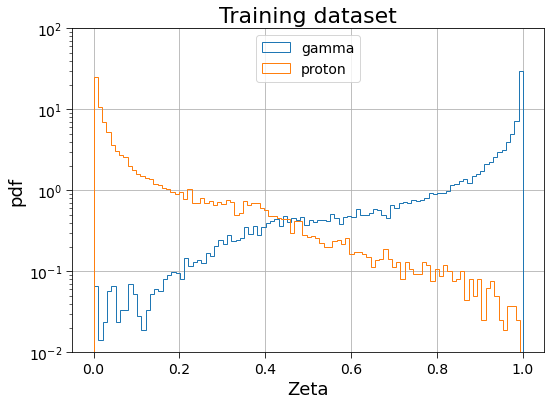

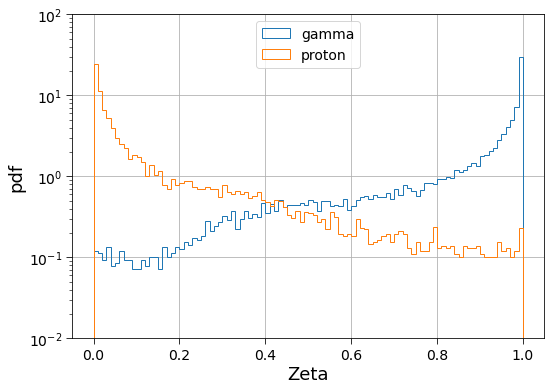

In [106]:
if test_train:
    train_labels = y_train.astype(bool)
    y_pred_train = model.predict(x_train)
    plt.figure()
    ghist = plt.hist(y_pred_train[train_labels], alpha=1, bins=100, density=True, log=True, histtype='step', label='gamma')
    phist = plt.hist(y_pred_train[~train_labels], alpha=1, bins=100, density=True, log=True, histtype='step', label='proton')
    plt.xlabel('Zeta')
    plt.ylabel('pdf')
    plt.legend(loc='upper center')
    plt.grid()
    plt.ylim(0.01, 100)
    plt.title('Training dataset')
    if save_plots:
        plt.savefig(plots_folder + 'gamma-hadron_zeta_%s_train_step1.pdf' % model_descr_str)


test_labels = y_test.astype(bool)
y_pred = model.predict(x_test)

plt.figure()
ghist = plt.hist(y_pred[test_labels], alpha=1, bins=100, density=True, log=True, histtype='step', label='gamma')
phist = plt.hist(y_pred[~test_labels], alpha=1, bins=100, density=True, log=True, histtype='step', label='proton')
plt.xlabel('Zeta')
plt.ylabel('pdf')
plt.legend(loc='upper center')
plt.grid()
plt.ylim(0.01, 100)
if save_plots:
    plt.savefig(plots_folder + 'gamma-hadron_zeta_%s_test_step1.pdf' % model_descr_str)

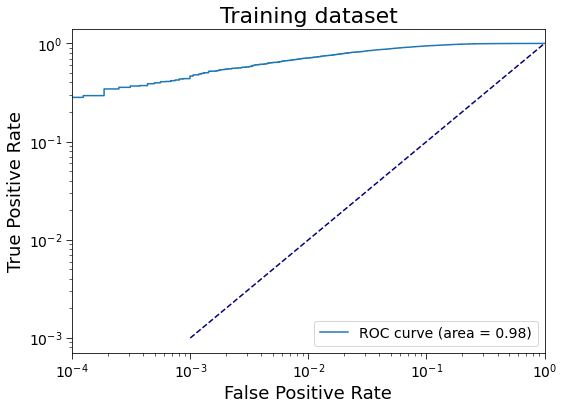

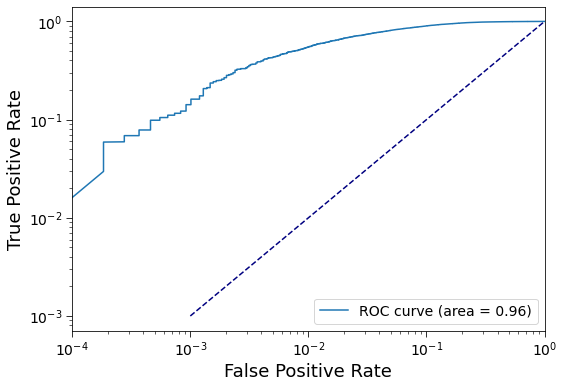

In [107]:
if test_train:
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train)
    roc_auc_train = auc(fpr_train, tpr_train)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

if test_train:
    plt.figure()
    plt.loglog(fpr_train, tpr_train, label="ROC curve (area = %0.2f)" % roc_auc_train)
    plt.loglog([0.001, 1], [0.001, 1], color="navy", linestyle="--")
    plt.xlim([1.e-4, 1.0])
    #plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.title('Training dataset')
    #plt.show()
    if save_plots:
        plt.savefig(plots_folder + 'ROC_%s_train_step1.pdf' % model_descr_str)
    
plt.figure()
plt.loglog(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.loglog([0.001, 1], [0.001, 1], color="navy", linestyle="--")
plt.xlim([1.e-4, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
#plt.show()
if save_plots:
    plt.savefig(plots_folder + 'ROC_%s_test_step1.pdf' % model_descr_str)

In [79]:
# alpha = 0.6 # part 3 in case 4
if cdict['two_step'] and (cdict['load_model'] is None or cdict['load_model'].endswith('part1')):
    #model.loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    model.loss = tfa.losses.SigmoidFocalCrossEntropy(gamma=gamma, alpha=alpha)
    # fit the model
    history = model.fit(x=x_train, 
                        y=y_train, 
                        #epochs=epochs, 
                        epochs=epochs, 
                        validation_data=(x_test, y_test),
                        #callbacks=[tensorboard_callback]
                       )

Epoch 1/10
3000/3000 [==============================] - 67s 22ms/step - loss: 0.2153 - accuracy: 0.9127 - val_loss: 0.2184 - val_accuracy: 0.9157
Epoch 2/10
3000/3000 [==============================] - 64s 21ms/step - loss: 0.2144 - accuracy: 0.9137 - val_loss: 0.2265 - val_accuracy: 0.9131
Epoch 3/10
3000/3000 [==============================] - 64s 21ms/step - loss: 0.2117 - accuracy: 0.9140 - val_loss: 0.2226 - val_accuracy: 0.9142
Epoch 4/10
3000/3000 [==============================] - 65s 22ms/step - loss: 0.2116 - accuracy: 0.9151 - val_loss: 0.2259 - val_accuracy: 0.9130
Epoch 5/10
3000/3000 [==============================] - 66s 22ms/step - loss: 0.2097 - accuracy: 0.9158 - val_loss: 0.2230 - val_accuracy: 0.9138
Epoch 6/10
3000/3000 [==============================] - 66s 22ms/step - loss: 0.2082 - accuracy: 0.9173 - val_loss: 0.2234 - val_accuracy: 0.9137
Epoch 7/10
3000/3000 [==============================] - 63s 21ms/step - loss: 0.2062 - accuracy: 0.9163 - val_loss: 0.2187 -

In [80]:
np.sort(os.listdir('../models/'))

array(['model_20220114-103214_10_epochs.h5',
       'model_20220114-145355_20_epochs.h5',
       'model_20220120-135551_20_epochs.h5',
       'model_20220122-141603_10_epochs.h5', 'model_case1.h5',
       'model_case2.h5', 'model_case2_part1.h5', 'model_case3.h5',
       'model_case3_part1.h5', 'model_case4_part1.h5',
       'model_case4_part2.h5'], dtype='<U34')

In [81]:
#save_model = True
if cdict['two_step'] and save_model and (cdict['load_model'] is None or cdict['load_model'].find('part1') > -1):
    print('save model')
    mdl_fn_part2 = mdl_fn.replace('.h5', '_part2.h5')
    print(mdl_fn_part2)
    model.save(mdl_fn_part2)


save model
../models/model_case4_part3.h5


In [22]:
Emin = cdict['mask_dict']['true_energy']['min']
Emax = cdict['mask_dict']['true_energy']['max']

if test_train:
    train_labels = y_train.astype(bool)
    y_pred_train = model.predict(x_train)
    
test_labels = y_test.astype(bool)
y_pred = model.predict(x_test)


In [108]:

if test_train:
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train)
    roc_auc_train = auc(fpr_train, tpr_train)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

imax, tpr_max, fpr_max, Qmax = get_max_Q(fpr, tpr)
thres_max = thresholds[imax]


In [109]:
print(imax, tpr_max, fpr_max, Qmax, thres_max)

400 0.3241551049448595 0.0024841291747170853 6.503779035298956 0.9863362


Save plot to file:
../plots/gamma-hadron_zeta_1-4TeV.pdf


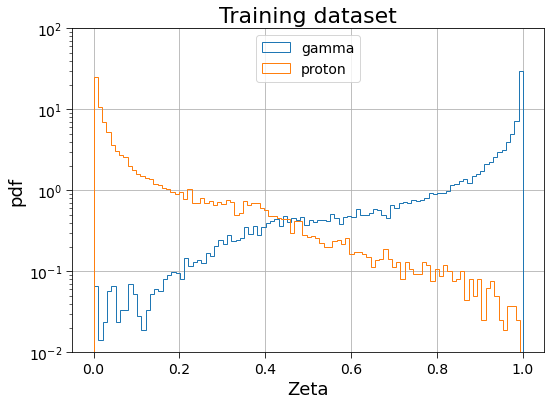

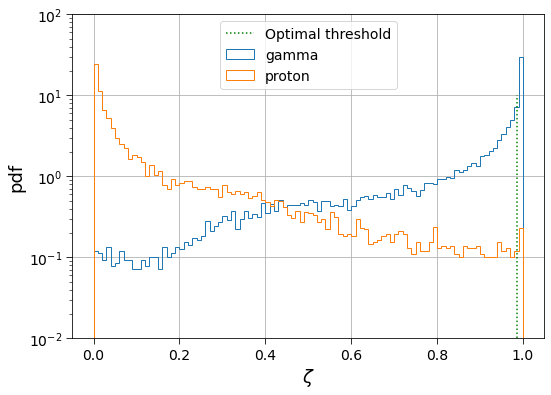

In [110]:

if test_train:
    plt.figure()
    ghist = plt.hist(y_pred_train[train_labels], alpha=1, bins=100, density=True, log=True, 
                     histtype='step', label='gamma')
    phist = plt.hist(y_pred_train[~train_labels], alpha=1, bins=100, density=True, log=True, 
                     histtype='step', label='proton')
    plt.xlabel('Zeta')
    plt.ylabel('pdf')
    plt.legend(loc='upper center')
    plt.grid()
    plt.ylim(0.01, 100)
    plt.title('Training dataset')
    if save_plots:
        plt.savefig(plots_folder + 'gamma-hadron_zeta_%s_train_step2.pdf' % model_descr_str)




plt.figure()
ghist = plt.hist(y_pred[test_labels], alpha=1, bins=100, density=True, log=True, histtype='step', label='gamma')
phist = plt.hist(y_pred[~test_labels], alpha=1, bins=100, density=True, log=True, histtype='step', label='proton')
plt.semilogy([thres_max, thres_max], [0.01, 10.], color="green", linestyle=":", label='Optimal threshold')
plt.xlabel(r'$\zeta$')
plt.ylabel('pdf')
plt.legend(loc='upper center')
plt.grid()
plt.ylim(0.01, 100)
if save_plots:
    if publish_version:
        fn = plots_folder + 'gamma-hadron_zeta_%i-%iTeV.pdf' % (Emin, Emax)
    else:
        fn = plots_folder + 'gamma-hadron_zeta_%s_test_step2.pdf' % model_descr_str
    print('Save plot to file:')
    print(fn)
    plt.savefig(fn)

Save plot to file:
../plots/ROC_case21_train_step2.pdf
Save plot to file:
../plots/ROC_1-4TeV.pdf


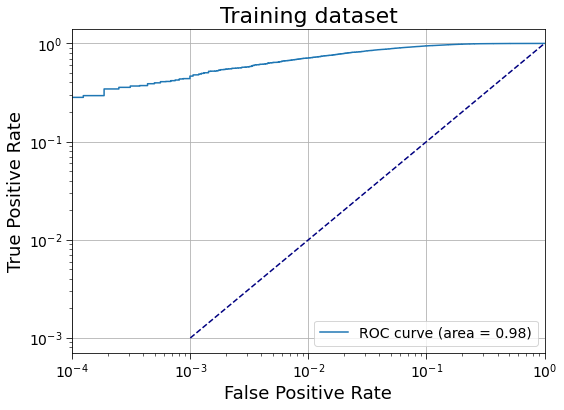

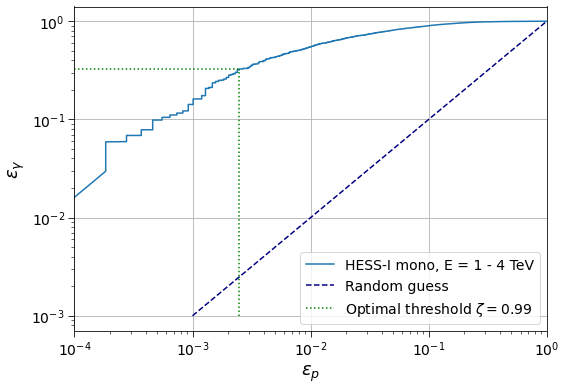

In [111]:


if test_train:
    plt.figure()
    plt.loglog(fpr_train, tpr_train, label="ROC curve (area = %0.2f)" % roc_auc_train)
    plt.loglog([0.001, 1], [0.001, 1], color="navy", linestyle="--")
    plt.xlim([1.e-4, 1.0])
    #plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.title('Training dataset')
    plt.grid()
    if save_plots:
        fn = plots_folder + 'ROC_%s_train_step2.pdf' % model_descr_str
        print('Save plot to file:')
        print(fn)
        plt.savefig(fn)


vmin = 0.001
xmin = 1.e-4
plt.figure()
if publish_version:
    label = 'HESS-I mono, E = %i - %i TeV' % (Emin, Emax)
else:
    label = "ROC curve (area = %0.2f)" % roc_auc
plt.loglog(fpr, tpr, label=label)
plt.loglog([vmin, 1], [vmin, 1], color="navy", linestyle="--", label='Random guess')
label = r'Optimal threshold $\zeta = %.2f$' % thresholds[imax]
plt.loglog([fpr_max, fpr_max], [vmin, tpr_max], color="green", linestyle=":", label=label)
plt.loglog([xmin, fpr_max], [tpr_max, tpr_max], color="green", linestyle=":")
plt.xlim([xmin, 1.0])
#plt.ylim([0.0, 1.05])
if publish_version:
    plt.xlabel(r"$\epsilon_p$")
    plt.ylabel(r"$\epsilon_\gamma$")
else:
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
#plt.title()
if save_plots:
    if publish_version:
        fn = plots_folder + 'ROC_%i-%iTeV.pdf' % (Emin, Emax)
    else:
        fn = plots_folder + 'ROC_%s_test_step2.pdf' % model_descr_str
    print('Save plot to file:')
    print(fn)
    plt.savefig(fn)

(0.001, 1)

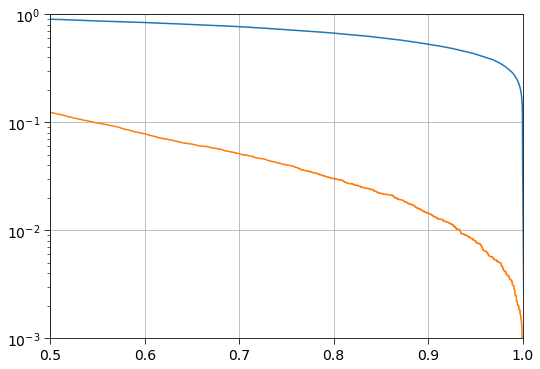

In [95]:
plt.semilogy(thresholds, tpr)
plt.semilogy(thresholds, fpr)
plt.grid()
plt.xlim(0.5, 1)
plt.ylim(0.001, 1)

/home/woody/caph/mpp228/apps/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


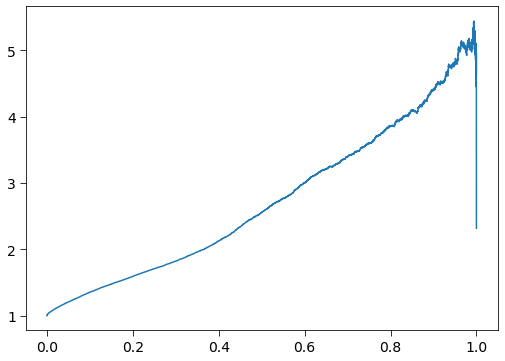

In [96]:
plt.plot(thresholds, tpr/np.sqrt(fpr))

In [98]:
Rg = 0.8
Rp = 0.05
print('std BDT:', Rg/np.sqrt(Rp))
Rg = 0.96
Rp = 0.0072
print('KE RF1:', Rg/np.sqrt(Rp))
Rg = 0.8
Rp = 0.0025
print('KE RF2:', Rg/np.sqrt(Rp))
Rg = 0.6
Rp = 0.001
print('KE RF3:', Rg/np.sqrt(Rp))

std BDT: 3.577708763999664
KE RF1: 11.31370849898476
KE RF2: 16.0
KE RF3: 18.973665961010276


In [97]:
np.sqrt(30), np.sqrt(300)

(5.477225575051661, 17.320508075688775)

In [35]:
if 0:
    train_labels = y_train.astype(bool)
    y_pred = model.predict(x_train)
    plt.figure()
    ghist = plt.hist(y_pred[train_labels], alpha=1, bins=100, density=True, log=True, histtype='step', label='gamma')
    phist = plt.hist(y_pred[~train_labels], alpha=1, bins=100, density=True, log=True, histtype='step', label='proton')
    plt.xlabel('Zeta')
    plt.ylabel('pdf')
    plt.legend(loc='upper center')
    plt.grid()

In [36]:
ghist[0][-10:], phist[0][-10:]

(array([3.52558525, 3.55386534, 3.6355634 , 3.77067941, 3.81467067,
        3.72042586, 3.8272396 , 4.0189158 , 4.49653519, 9.86346888]),
 array([0.15230721, 0.12122411, 0.10879151, 0.09946593, 0.06527452,
        0.09324931, 0.06216621, 0.05284159, 0.03729973, 0.06838283]))

In [37]:
def e2c(bins):
    return (bins[1:] + bins[:-1])/2.

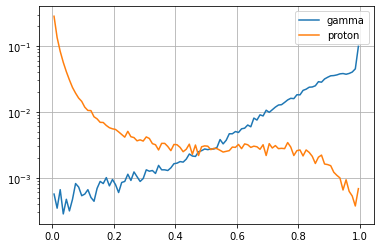

In [38]:

plt.figure()
plt.semilogy(e2c(ghist[1]), ghist[0]/np.sum(ghist[0]), label='gamma')
plt.semilogy(e2c(phist[1]), phist[0]/np.sum(phist[0]), label='proton')
plt.grid()
plt.legend()

In [39]:
y_pred[test_labels][3][0]

0.2701052

In [40]:
if save_model:
    model_test = tf.keras.models.load_model(mdl_fn)
    y_pred = model_test.predict(x_test)
    plt.figure()
    plt.hist(y_pred[test_labels], alpha=0.5, bins=100, label='gamma');
    plt.hist(y_pred[~test_labels], alpha=0.5, bins=100, label='proton');
    plt.legend()

OSError: SavedModel file does not exist at: ../models/model_case4.h5/{saved_model.pbtxt|saved_model.pb}

In [99]:
# plot gamma-like protons
thres = 0.95
gp_mask = (y_test == 0.) & (y_pred.T[0] > thres)
gp_images = x_test[gp_mask,:,:,0]
gg_mask = (y_test == 1.) & (y_pred.T[0] > thres)
gg_images = x_test[gg_mask,:,:,0]
ngp = sum(gp_mask)
ngg = sum(gg_mask)
print(ngp / ngg)

0.014468651255612839


../plots/gamma-like_protons_case21.pdf


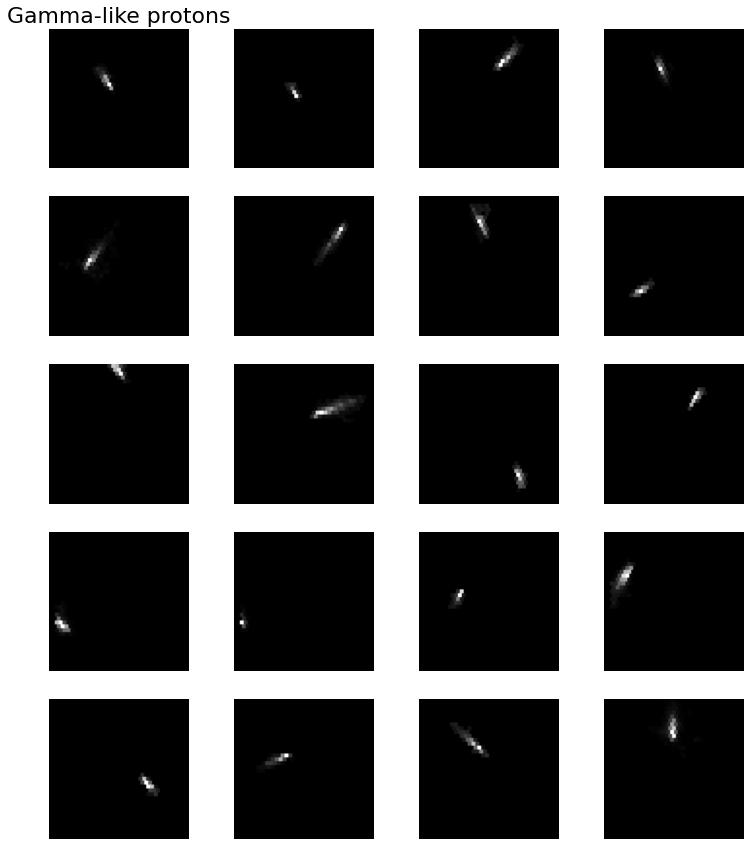

In [101]:
nraw = 5
ncol = 4
nplot = np.minimum(nraw * ncol, ngp)
size = 3
fig = plt.figure(figsize=(size*ncol, size*nraw))
plot_inds = np.random.choice(ngp, size=nplot, replace=False)
for i, ind in enumerate(plot_inds):
    plt.subplot(nraw, ncol, i + 1)
    plt.imshow(gp_images[ind], cmap='gray', vmin=0)
    plt.axis('off')
    if i == 0:
        plt.title('Gamma-like protons');
#plt.suptitle('Gamma-like protons');
fn = plots_folder + 'gamma-like_protons_%s.pdf' % model_descr_str
print(fn)
plt.savefig(fn)

../plots/gamma_showers_case21.pdf


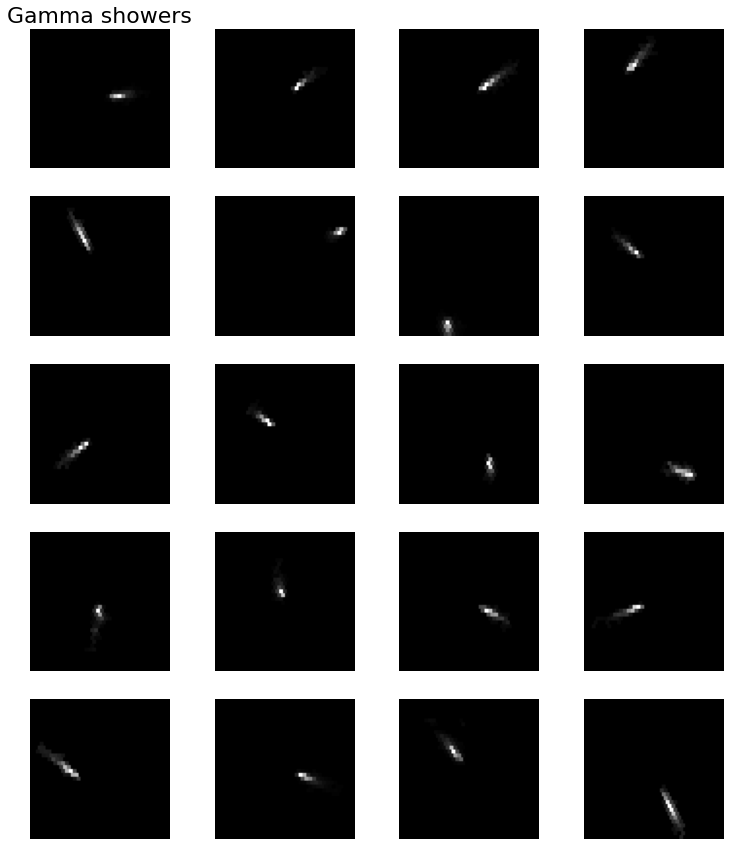

In [103]:
fig = plt.figure(figsize=(size*ncol, size*nraw))
plot_inds = np.random.choice(ngg, size=nplot, replace=False)
for i, ind in enumerate(plot_inds):
    plt.subplot(nraw, ncol, i + 1)
    plt.imshow(gg_images[ind], cmap='gray', vmin=0)
    plt.axis('off')
    if i == 0:
        plt.title('Gamma showers');
#plt.suptitle('Gamma showers');
fn = plots_folder + 'gamma_showers_%s.pdf' % model_descr_str
print(fn)
plt.savefig(fn)

In [112]:
thress = np.arange(0.9, 1., 0.002)
sep = np.zeros_like(thress)
Rgs = np.zeros_like(thress)
Rps = np.zeros_like(thress)
ngamma = np.sum(test_labels)
nproton = np.sum(~test_labels)
for i, thres in enumerate(thress):
    sep[i] = np.sum(y_pred[~test_labels] > thres) / np.sum(y_pred[test_labels] > thres)
    Rgs[i] = np.sum(y_pred[test_labels] > thres) / ngamma
    Rps[i] = np.sum(y_pred[~test_labels] > thres) / nproton
    keep = Rgs

In [113]:
if 0:
    import plot_utils
    plot_utils.setup_figure_pars()

In [114]:
if 0:
    importlib.reload(plot_utils)
    plot_utils.setup_figure_pars()

/home/woody/caph/mpp228/apps/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  import sys


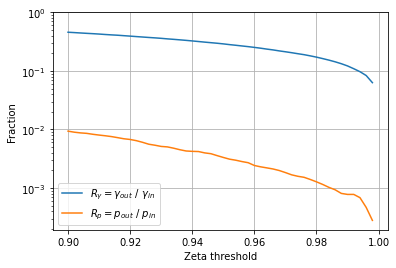

In [115]:
plt.figure()
plt.semilogy(thress, Rgs, label='$R_\gamma = \gamma_{out}\ /\ \gamma_{in}$')
plt.semilogy(thress, Rps, label='$R_p = p_{out}\ /\ p_{in}$')
#plt.semilogy(thress, sep, ls='--', label='$R_p\ /\ R_\gamma$')
plt.xlabel('Zeta threshold')
plt.ylabel('Fraction')
plt.ylim(0, 1)
plt.legend()
plt.grid()

In [116]:
print(thress)
print(Rgs)
print(Rps)

[0.9   0.902 0.904 0.906 0.908 0.91  0.912 0.914 0.916 0.918 0.92  0.922
 0.924 0.926 0.928 0.93  0.932 0.934 0.936 0.938 0.94  0.942 0.944 0.946
 0.948 0.95  0.952 0.954 0.956 0.958 0.96  0.962 0.964 0.966 0.968 0.97
 0.972 0.974 0.976 0.978 0.98  0.982 0.984 0.986 0.988 0.99  0.992 0.994
 0.996 0.998]
[0.45756747 0.45134634 0.44455965 0.43824426 0.43243158 0.42602193
 0.41863826 0.41229145 0.40673013 0.39956641 0.39284256 0.38571025
 0.37914349 0.37254532 0.36660697 0.36010306 0.35246803 0.34612122
 0.33927169 0.33242216 0.32506991 0.3176234  0.31014547 0.30342162
 0.29682345 0.28943978 0.2812392  0.27413831 0.26675464 0.25974801
 0.25214441 0.24435228 0.23577466 0.22839099 0.21968769 0.2122726
 0.20460615 0.19665693 0.18936752 0.18069564 0.17183523 0.1622836
 0.15282622 0.14305464 0.13268608 0.12156345 0.10896409 0.09693028
 0.08338832 0.06299683]
[0.00935567 0.00898269 0.00873403 0.00857862 0.0082678  0.00801915
 0.00780157 0.00755292 0.0072421  0.00693128 0.00674479 0.00643397
 0.

In [ ]:
#plt.hist(pars_dict['hillas_intensity'].flatten(), bins=np.arange(0, 1000, 50));

In [ ]:
#plt.hist(np.log10(pars_dict['true_energy'].flatten()), bins=np.linspace(-1, 3, 40));

In [ ]:
npix_signal = np.sum(np.heaviside(images[mask], 0.), axis=(1,2))

In [ ]:
#npix_signal_crop = np.sum(np.heaviside(cropped_images[mask], 0.), axis=(1,2))

In [ ]:
plt.hist(npix_signal, bins=np.arange(0,1000, 10));

In [ ]:
#plt.hist(npix_signal_crop, bins=np.arange(0,1000, 5));

In [ ]:
# https://www.cta-observatory.org/wp-content/uploads/2019/12/CTA-Specifications_v08_formatted.pdf
# signal / background
F_e = 1.e-4 # EdN/dE (1/m^2 s sr) -> 100 GeV^2 / m^2 s sr (@1 TeV)
F_p = 1.e-1 # 1/m^2 s sr
#Om = np.deg2rad(1.5)**2 * np.pi # LST
Om = np.deg2rad(3)**2 * np.pi # MST
A = 1.e5 # m^2
t = 1000 * 3600 # 1000 hours (at 1 TeV)
nbins_per_dec = 6
def dEoE(bins_per_dec):
    f = 10**(1./(2. * bins_per_dec))
    return (f - 1./f)

zeta = 0.95
ind = np.argmin((thress - zeta)**2)
if 1:
    # standard BDT rejection
    rej_g = 0.8
    rej_p = 0.05
    sep0 = rej_p / rej_g
elif 0:
    rej_g = keep[ind]
    #sep0 = sep[ind]
    sep0 = 0.01
    rej_p = keep[ind] * sep0

N_e = rej_g * F_e * Om * A * t * dEoE(nbins_per_dec)
N_p = rej_p * F_p * Om * A * t * dEoE(nbins_per_dec)
print(N_e, N_p, np.sqrt(N_p), sep0)
print(N_e / np.sqrt(N_p))

In [ ]:
print(rej_g, rej_p,  dEoE(nbins_per_dec))
print(N_e/rej_g, N_p/rej_p)

In [ ]:
Es = np.logspace(-1, 3, nbins_per_dec * 4 + 1)

In [ ]:
Nes = N_e * Es**(-2.3)
Nps = N_p * Es**(-1.7)
plt.rcParams['legend.fontsize'] = 12
plt.figure()
plt.loglog(Es, Nes / (np.sqrt(Nps) * np.sqrt(0.1)/np.sqrt(sep0)), label='p/gamma = 10%')
plt.loglog(Es, Nes / np.sqrt(Nps), label='p/gamma = %i' % (sep0 * 100))
plt.loglog(Es, Nes / (np.sqrt(Nps) * np.sqrt(0.001)/np.sqrt(sep0)), label='p/gamma = 0.1%')
Nes3 = Nes * dEoE(3) / dEoE(nbins_per_dec)
Nps3 = Nps * dEoE(3) / dEoE(nbins_per_dec)
plt.loglog(Es, Nes3 / np.sqrt(Nps3), ls=':', label='p/g = 1%, 3 bins/dec')
plt.grid()
plt.xlabel('E (TeV)')
plt.ylabel('significance')
plt.legend(loc='upper right')
#plt.ylim(1.e-4, 1.e6)